# Source

Modified cloud simulator

Source: Cloud-sim by Tomas Vondra
https://github.com/vondrt4/cloud-sim

In [2]:
library(pdq)
library(queueing)

In [3]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Debian GNU/Linux 10 (buster)

Matrix products: default
BLAS/LAPACK: /home/jakub/.conda/envs/bp_thesis_pyr/lib/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] queueing_0.2.12 pdq_6.2-0       repr_0.19.2    

loaded via a namespace (and not attached):
 [1] compiler_3.6.1  IRdisplay_0.7.0 pbdZMQ_0.3-3    tools_3.6.1    
 [5] htmltools_0.3.6 base64enc_0.1-3 crayon_1.3.4    Rcpp_1.0.6     
 [9] uuid_0.1-2      IRkernel_0.8.15 jsonlite_1.6    digest

In [4]:
request_series <- read.csv("../../data/corrected_m2/corrected_data_2_15m_anomaly_free.csv")

In [5]:
forecasts_arimax_15 <- read.csv("../../data/forecasts/total_arimax_forecasts_15.csv")
forecasts_hts_speculative_15 <- read.csv("../../data/forecasts/total_hts_speculative_15.csv")
forecasts_hts_rt_15 <- read.csv("../../data/forecasts/total_hts_rt_15.csv")
forecasts_hts_oracle_15 <- read.csv("../../data/forecasts/total_hts_oracle_15.csv")

In [6]:
forecasts_mean_5_arimax_1 <- read.csv("../../data/forecasts/5-mean-arimax-1min.csv")
forecasts_mean_5_oracle_1 <- read.csv("../../data/forecasts/5-mean-oracle-1min.csv")
forecasts_mean_5_rt_1 <- read.csv("../../data/forecasts/5-mean-rt-1min.csv")
forecasts_mean_5_speculative_1 <- read.csv("../../data/forecasts/5-mean-speculative-1min.csv")
forecasts_mean_20_arimax_1 <- read.csv("../../data/forecasts/20-mean-arimax-1min.csv")
forecasts_mean_20_oracle_1 <- read.csv("../../data/forecasts/20-mean-oracle-1min.csv")
forecasts_mean_20_rt_1 <- read.csv("../../data/forecasts/20-mean-rt-1min.csv")
forecasts_mean_20_speculative_1 <- read.csv("../../data/forecasts/20-mean-speculative-1min.csv")

In [7]:
simstep<-15        #how long is one step in minutes?
simtime<-simstep*1501 #how long will the simulation run?
machines_min<-1    #minimal number of machines
machines_max<-32    #maximal number of machines
demand<-0.0256#0.0306 #service demand of one request in s
ApdexS_goal<-0.03 #0.04#0.09  #parameter for GoS calculation in s
ApdexC_goal<-1     #leave at 1
multiplier<-1/900*16
offset<-3560

In [8]:
series <- request_series$count

In [9]:
sixplot<-function(){
  par(mfrow=c(3,2),cex=0.5)
  plot(xc, lambda, type="S", xaxp=c(0,simtime,simtime/simstep), xlim=c(0,simtime), col="blue", main="Load", xlab="time (min)", ylab="req/s lambda(N)")
  plot(xc, uc, type="S", xaxp=c(0,simtime,simtime/simstep), xlim=c(0,simtime), col="blue", main="Utilization", xlab="time (min)", ylab="% U(N)")
  plot(xc, qc, type="S", xaxp=c(0,simtime,simtime/simstep), xlim=c(0,simtime), col="blue", main="Queue Length", xlab="time (min)", ylab="reqs Q(N)")
  plot(xc, rc, type="S", xaxp=c(0,simtime,simtime/simstep), xlim=c(0,simtime), col="blue", main="Response Time", xlab="time (min)", ylab="ms R(N)")
  plot(xc, machines, type="S", xaxp=c(0,simtime,simtime/simstep), xlim=c(0,simtime), col="blue", main="Machines", xlab="time (min)", ylab="machines")
  plot(xc, ApdexS$overall, type="S", xaxp=c(0,simtime,simtime/simstep), xlim=c(0,simtime), col="blue", main="ApdexS", xlab="time (min)", ylab="overall")
}

In [19]:
sim_loop <-function(method, up, down, predictive_up = 65, predictive_down = 35, stdout=TRUE){ # todo predictive up --> 70, predictive down 35
    #Initializations
    machines<-10        #initial number of machines
    steps<-2         #we actually start at index 2. Needed for stair-step graphs.
    machines[2]<-machines[1] 
    lambda<-0;
    mu<-1/demand     #trivial formula
    added_before<-0  #the cooldown timer
    starts<-0
    stops<-0
    
    #Result variables
    xc<-0  #time coordinates
    uc<-0  #PDQ utilizations
    qc<-0  #PDQ queue lenghts
    rc<-0  #PDQ response times
    
    for (i in seq(from=simstep,to=simtime,by=simstep)){
        
        #Define load
        lambda[steps]<-series[offset+steps]*multiplier
        #print(multiplier)
        #print(series[offset+steps])
        #print(lambda[steps])
        #print(series[offset+steps]*multiplier)
        #Simulate  
        #Check for overload condition (lambda>mu)
        if (lambda[steps]<(machines[steps]/demand)){
            #If there was an overload on the previous period
            if (qc[steps-1]>-simstep*60*(lambda[steps]-(machines[steps]/demand))){
            ##queue bigger than can be serviced in one step
            #Amortize queue 
              xc[steps] <- i
              uc[steps] <- 1
              qc[steps] <- qc[steps-1]+simstep*60*(lambda[steps]-(machines[steps]/demand))
              ##last step steady-state queue length + how many will have accumulated for one simulation step - should be nagative
              rc[steps] <- demand/machines[steps]*(1+qc[steps])*1000
              ##R=D/M*(1+q)
            } else {
            #Define and solve the PDQ model
              pdq::Init("model")    
              pdq::CreateOpen("requests", lambda[steps])
              pdq::CreateMultiNode(machines[steps], "WebServer", CEN, MSQ)#, MSO, FCFS)#, CEN, MSO)
              pdq::SetDemand("WebServer", "requests", demand)
              pdq::Solve(CANON)
            #Extract results  
              xc[steps] <- i
              uc[steps] <- pdq::GetUtilization("WebServer", "requests", TRANS)
              qc[steps] <- pdq::GetQueueLength("WebServer", "requests", TRANS)
              rc[steps] <- pdq::GetResponse(TRANS, "requests") * 10^3
            }
          } else { 
           #Estimate overload parameters
            xc[steps] <- i
            uc[steps] <- 1 ##lambda[steps]/(machines[steps]/demand)
            ##U=lambda/mu - goes over 100%
            qc[steps] <- qc[steps-1]+simstep*60*(lambda[steps]-(machines[steps]/demand))
            ##last step steady-state queue length + how many will have accumulated for one simulation step
            rc[steps] <- demand/machines[steps]*(1+qc[steps])*1000
            ##R=D/M*(1+q)
          }
        #print(uc[steps])
        
        utilization<-function(fast_up,up,down){
            if (uc[steps]>=fast_up) {
              return(machines[steps]+4)
            } else if (uc[steps]>=up) {
              return(machines[steps]+1)
            } else if (uc[steps]<=down && added_before<0){
              return(machines[steps]-1)
            } else {
              return(machines[steps])
            }
        }

        latency<-function(fast_up,up,down){
            if (rc[steps]>=fast_up) {
              return(machines[steps]+4)
            } else if (rc[steps]>=up) {
              return(machines[steps]+1)
            } else if (rc[steps]<=down && added_before<0){
              return(machines[steps]-1)
            } else {
              return(machines[steps])
            }
        }

        queue<-function(fast_up,up,down){
            if (qc[steps]>=fast_up) {
              return(machines[steps]+4)
            } else if (qc[steps]>=up) {
              return(machines[steps]+1)
            } else if (qc[steps]<=down && added_before<0){
              return(machines[steps]-1)
            } else {
              return(machines[steps])
            }
        }

        hybridlq<-function(fast_up,up,down){
            if (qc[steps]>=fast_up) {
              return(machines[steps]+4)
            } else if (rc[steps]>=up) {
              return(machines[steps]+1)
            } else if (qc[steps]<=down && added_before<0){
              return(machines[steps]-1)
            } else {
              return(machines[steps])
            }
        }

        hybridlu<-function(fast_up,up,down){
            if (qc[steps]>=fast_up) {
              return(machines[steps]+4)
            } else if (rc[steps]>=up) {
              return(machines[steps]+1)
            } else if (uc[steps]<=down && added_before<0){
              return(machines[steps]-1)
            } else {
              return(machines[steps])
            }
          }
        
        static_16<-function(){
            return(16)
        }
        
        forecast_scale_15<-function(up, down, steps_ahead, forecasts){
            # Forecast failed
            if(uc[steps] >= (predictive_up / 100)){
                #cat("failed up", uc[steps], uc[steps] > 0.90,"\n")
                return(machines[steps]+2)
            }else if (uc[steps] <= (predictive_down / 100)){
                #cat("failed dw", uc[steps], uc[steps] <= 0.40,"\n")
                return(machines[steps]-1)
            }
            if(advanced){
                if(uc[steps] >= 0.50){
                    if (lambda[steps] + up < forecasts[steps, steps_ahead + 1] * multiplier){
                        return(machines[steps]+1)
                    }
                    return(machines[steps])
                }
                else if(uc[steps] < 0.50){
                    if (lambda[steps] - down > forecasts[steps, steps_ahead + 1] * multiplier){
                        return(machines[steps]-1)
                    }
                    return(machines[steps])
                }   
            }
            

            if (lambda[steps] + up < forecasts[steps, steps_ahead + 1] * multiplier){
                    return(machines[steps]+1)
            }
            if (lambda[steps] - down > forecasts[steps, steps_ahead + 1] * multiplier){
                    return(machines[steps]-1)
            }
            return(machines[steps])
        }
        
        forecast_scale_15_cooldown<-function(up, down, steps_ahead, forecasts){
            # Forecast failed
            if(uc[steps] >= (predictive_up / 100)){
                #cat("failed up", uc[steps], uc[steps] > 0.90,"\n")
                return(machines[steps]+2)
            }else if (uc[steps] <= (predictive_down / 100) && added_before<0){
                #cat("failed dw", uc[steps], uc[steps] <= 0.40,"\n")
                return(machines[steps]-1)
            }
            if(advanced){
                if(uc[steps] >= 0.75){
                    if (lambda[steps] + up < forecasts[steps, steps_ahead + 1] * multiplier){
                        return(machines[steps]+1)
                    }
                    return(machines[steps])
                }
                else if(uc[steps] <= 0.55){
                    if (lambda[steps] - down > forecasts[steps, steps_ahead + 1] * multiplier && added_before<0){
                        return(machines[steps]-1)
                    }
                    return(machines[steps])
                }   
            }
            

            if (lambda[steps] + up < forecasts[steps, steps_ahead + 1] * multiplier){
                    return(machines[steps]+1)
            }
            if (lambda[steps] - down > forecasts[steps, steps_ahead + 1] * multiplier && added_before<0){
                    return(machines[steps]-1)
            }
            return(machines[steps])
        }
        
        
        forecast_observed<-function(up, down, steps_ahead){
            # Forecast failed
            if(uc[steps] >= (predictive_up / 100)){
                #cat("failed up", uc[steps], uc[steps] > (predictive_up / 100),"\n")
                return(machines[steps]+2)
            }else if (uc[steps] <= (predictive_down / 100)){
                #cat("failed dw", uc[steps], uc[steps] <= (predictive_down / 100),"\n")
                return(machines[steps]-1)
            }
            #print(steps+offset)
            if(advanced){
                if(uc[steps] >= 0.75){
                    if (lambda[steps] + up < series[steps+offset+steps_ahead] * multiplier){
                        #print("up")
                        return(machines[steps]+1)
                    }
                    return(machines[steps])
                }
                else if(uc[steps] <= 0.55){
                    if (lambda[steps] - down > series[steps+offset+steps_ahead] * multiplier){
                        #print("down")
                        return(machines[steps]-1)
                    }
                    return(machines[steps])
                }   
            }

            if (lambda[steps] + up < series[steps+offset+steps_ahead] * multiplier){
                #print("up")    
                return(machines[steps]+1)
            }
            if (lambda[steps] - down > series[steps+offset+steps_ahead] * multiplier){
                #print("down")    
                return(machines[steps]-1)
            }
            #print("ok")
            return(machines[steps])
        }
        
        forecast_observed_cooldown<-function(up, down, steps_ahead){
            # Forecast failed
            if(uc[steps] >= (predictive_up / 100)){
                #cat("failed up", uc[steps], uc[steps] > (predictive_up / 100),"\n")
                return(machines[steps]+2)
            }else if (uc[steps] <= (predictive_down / 100) && added_before<0){
                #cat("failed dw", uc[steps], uc[steps] <= (predictive_down / 100),"\n")
                return(machines[steps]-1)
            }
            #print(steps+offset)
            if(advanced){
                if(uc[steps] >= 0.75){
                    if (lambda[steps] + up < series[steps+offset+steps_ahead] * multiplier){
                        #print("up")
                        return(machines[steps]+1)
                    }
                    return(machines[steps])
                }
                else if(uc[steps] <= 0.55){
                    if (lambda[steps] - down > series[steps+offset+steps_ahead] * multiplier && added_before<0){
                        #print("down")
                        return(machines[steps]-1)
                    }
                    return(machines[steps])
                }   
            }

            if (lambda[steps] + up < series[steps+offset+steps_ahead] * multiplier){
                #print("up")    
                return(machines[steps]+1)
            }
            if (lambda[steps] - down > series[steps+offset+steps_ahead] * multiplier && added_before<0){
                #print("down")    
                return(machines[steps]-1)
            }
            #print("ok")
            return(machines[steps])
        }
        
        forecast_observed_hybrid_cooldown<-function(up, down, steps_ahead){
            if(uc[steps] >= (predictive_up / 100)){
                #print("RUP")
                return(machines[steps]+2)
            }else if (uc[steps] <= (down/100) && added_before<0){
                return(machines[steps]-1)
            }
            if (lambda[steps] + up < series[steps+offset+steps_ahead] * multiplier){
                #print("P UP")
                return(machines[steps]+1)
            }
            return(machines[steps])
        }
        
        forecast_scale_hybrid_cooldown<-function(up, down, steps_ahead, forecasts){
            if(uc[steps] >= (predictive_up / 100)){
                #print("RUP")
                return(machines[steps]+2)
            }else if (uc[steps] <= (down/100) && added_before<0){
                return(machines[steps]-1)
            }
            if (lambda[steps] + up < forecasts[steps, steps_ahead + 1] * multiplier){
                #print("P UP")
                return(machines[steps]+1)
            }
            return(machines[steps])
        }
        
        
        
        # These else ifs are horrible
        # TODO switch
        
        # Switch in R isn't much better....
        #machines[steps+1]<-switch("utilization" = {utilization(1.95,up/100,down/100)}, ...)
        
        
        #Call one:
        if(method=="utilization"){
            machines[steps+1]<-utilization(1.95,up/100,down/100)   
        }else if(method=="latency"){
            machines[steps+1]<-latency(350000,up,down)
        }else if(method=="queue"){
            machines[steps+1]<-queue(1000000,up,down)
        }else if(method=="hybridlq"){
            machines[steps+1]<-hybridlq(1000000,up,down)
        }else if(method=="hybridlu"){
            machines[steps+1]<-hybridlu(1000000,up,down/100)
        }else if(method=="arimax-1-15"){
            machines[steps+1]<-forecast_scale_15(up, down, 1, forecasts_arimax_15)
        }else if(method=="arimax-2-15"){
            machines[steps+1]<-forecast_scale_15(up, down, 2, forecasts_arimax_15)
        }else if(method=="arimax-3-15"){
            machines[steps+1]<-forecast_scale_15(up, down, 3, forecasts_arimax_15)
        }else if(method=="rt-1-15"){
            machines[steps+1]<-forecast_scale_15(up, down, 1, forecasts_hts_rt_15)
        }else if(method=="rt-2-15"){
            machines[steps+1]<-forecast_scale_15(up, down, 2, forecasts_hts_rt_15)
        }else if(method=="rt-3-15"){
            machines[steps+1]<-forecast_scale_15(up, down, 3, forecasts_hts_rt_15)
        }else if(method=="speculative-1-15"){
            machines[steps+1]<-forecast_scale_15(up, down, 1, forecasts_hts_speculative_15)
        }else if(method=="speculative-2-15"){
            machines[steps+1]<-forecast_scale_15(up, down, 2, forecasts_hts_speculative_15)
        }else if(method=="speculative-3-15"){
            machines[steps+1]<-forecast_scale_15(up, down, 3, forecasts_hts_speculative_15)
        }else if(method=="oracle-1-15"){
            machines[steps+1]<-forecast_scale_15(up, down, 1, forecasts_hts_oracle_15)
        }else if(method=="oracle-2-15"){
            machines[steps+1]<-forecast_scale_15(up, down, 2, forecasts_hts_oracle_15)
        }else if(method=="oracle-3-15"){
            machines[steps+1]<-forecast_scale_15(up, down, 3, forecasts_hts_oracle_15)
        }else if(method=="mean-arimax-5-1"){
            machines[steps+1]<-forecast_scale_15(up, down, 1, forecasts_mean_5_arimax_1)
        }else if(method=="mean-rt-5-1"){
            machines[steps+1]<-forecast_scale_15(up, down, 1, forecasts_mean_5_rt_1)
        }else if(method=="mean-speculative-5-1"){
            machines[steps+1]<-forecast_scale_15(up, down, 1, forecasts_mean_5_speculative_1)
        }else if(method=="mean-oracle-5-1"){
            machines[steps+1]<-forecast_scale_15(up, down, 1, forecasts_mean_5_oracle_1)
        }else if(method=="real-observations-1"){
            machines[steps+1]<-forecast_observed(up, down, 1)
        }else if(method=="real-observations-2"){
            machines[steps+1]<-forecast_observed(up, down, 2)
        }else if(method=="real-observations-3"){
            machines[steps+1]<-forecast_observed(up, down, 3)
        }else if(method=="static-16"){
            machines[steps+1]<-static_16()
        }else if(method=="real-observations-1-cd"){
            machines[steps+1]<-forecast_observed_cooldown(up, down, 1)
        }else if(method=="real-observations-2-cd"){
            machines[steps+1]<-forecast_observed_cooldown(up, down, 2)
        }else if(method=="real-observations-3-cd"){
            machines[steps+1]<-forecast_observed_cooldown(up, down, 3)
        }else if(method=="arimax-1-15-cd"){
            machines[steps+1]<-forecast_scale_15_cooldown(up, down, 1, forecasts_arimax_15)
        }else if(method=="arimax-2-15-cd"){
            machines[steps+1]<-forecast_scale_15_cooldown(up, down, 2, forecasts_arimax_15)
        }else if(method=="arimax-3-15-cd"){
            machines[steps+1]<-forecast_scale_15_cooldown(up, down, 3, forecasts_arimax_15)
        }else if(method=="rt-1-15-cd"){
            machines[steps+1]<-forecast_scale_15_cooldown(up, down, 1, forecasts_hts_rt_15)
        }else if(method=="rt-2-15-cd"){
            machines[steps+1]<-forecast_scale_15_cooldown(up, down, 2, forecasts_hts_rt_15)
        }else if(method=="rt-3-15-cd"){
            machines[steps+1]<-forecast_scale_15_cooldown(up, down, 3, forecasts_hts_rt_15)
        }else if(method=="speculative-1-15-cd"){
            machines[steps+1]<-forecast_scale_15_cooldown(up, down, 1, forecasts_hts_speculative_15)
        }else if(method=="speculative-2-15-cd"){
            machines[steps+1]<-forecast_scale_15_cooldown(up, down, 2, forecasts_hts_speculative_15)
        }else if(method=="speculative-3-15-cd"){
            machines[steps+1]<-forecast_scale_15_cooldown(up, down, 3, forecasts_hts_speculative_15)
        }else if(method=="oracle-1-15-cd"){
            machines[steps+1]<-forecast_scale_15_cooldown(up, down, 1, forecasts_hts_oracle_15)
        }else if(method=="oracle-2-15-cd"){
            machines[steps+1]<-forecast_scale_15_cooldown(up, down, 2, forecasts_hts_oracle_15)
        }else if(method=="oracle-3-15-cd"){
            machines[steps+1]<-forecast_scale_15_cooldown(up, down, 3, forecasts_hts_oracle_15)
        }else if(method=="mean-arimax-5-1-cd"){
            machines[steps+1]<-forecast_scale_15_cooldown(up, down, 1, forecasts_mean_5_arimax_1)
        }else if(method=="mean-rt-5-1-cd"){
            machines[steps+1]<-forecast_scale_15_cooldown(up, down, 1, forecasts_mean_5_rt_1)
        }else if(method=="mean-speculative-5-1-cd"){
            machines[steps+1]<-forecast_scale_15_cooldown(up, down, 1, forecasts_mean_5_speculative_1)
        }else if(method=="mean-oracle-5-1-cd"){
            machines[steps+1]<-forecast_scale_15_cooldown(up, down, 1, forecasts_mean_5_oracle_1)
        }else if(method=="arimax-1-15-h"){
            machines[steps+1]<-forecast_scale_hybrid_cooldown(up, down, 1, forecasts_arimax_15)
        }else if(method=="arimax-2-15-h"){
            machines[steps+1]<-forecast_scale_hybrid_cooldown(up, down, 2, forecasts_arimax_15)
        }else if(method=="arimax-3-15-h"){
            machines[steps+1]<-forecast_scale_hybrid_cooldown(up, down, 3, forecasts_arimax_15)
        }else if(method=="rt-1-15-h"){
            machines[steps+1]<-forecast_scale_hybrid_cooldown(up, down, 1, forecasts_hts_rt_15)
        }else if(method=="rt-2-15-h"){
            machines[steps+1]<-forecast_scale_hybrid_cooldown(up, down, 2, forecasts_hts_rt_15)
        }else if(method=="rt-3-15-h"){
            machines[steps+1]<-forecast_scale_hybrid_cooldown(up, down, 3, forecasts_hts_rt_15)
        }else if(method=="speculative-1-15-h"){
            machines[steps+1]<-forecast_scale_hybrid_cooldown(up, down, 1, forecasts_hts_speculative_15)
        }else if(method=="speculative-2-15-h"){
            machines[steps+1]<-forecast_scale_hybrid_cooldown(up, down, 2, forecasts_hts_speculative_15)
        }else if(method=="speculative-3-15-h"){
            machines[steps+1]<-forecast_scale_hybrid_cooldown(up, down, 3, forecasts_hts_speculative_15)
        }else if(method=="oracle-1-15-h"){
            machines[steps+1]<-forecast_scale_hybrid_cooldown(up, down, 1, forecasts_hts_oracle_15)
        }else if(method=="oracle-2-15-h"){
            machines[steps+1]<-forecast_scale_hybrid_cooldown(up, down, 2, forecasts_hts_oracle_15)
        }else if(method=="oracle-3-15-h"){
            machines[steps+1]<-forecast_scale_hybrid_cooldown(up, down, 3, forecasts_hts_oracle_15)
        }else if(method=="mean-arimax-5-1-h"){
            machines[steps+1]<-forecast_scale_hybrid_cooldown(up, down, 1, forecasts_mean_5_arimax_1)
        }else if(method=="mean-rt-5-1-h"){
            machines[steps+1]<-forecast_scale_hybrid_cooldown(up, down, 1, forecasts_mean_5_rt_1)
        }else if(method=="mean-speculative-5-1-h"){
            machines[steps+1]<-forecast_scale_hybrid_cooldown(up, down, 1, forecasts_mean_5_speculative_1)
        }else if(method=="mean-oracle-5-1-h"){
            machines[steps+1]<-forecast_scale_hybrid_cooldown(up, down, 1, forecasts_mean_5_oracle_1)
        }else if(method=="real-observations-1-h"){
            machines[steps+1]<-forecast_observed_hybrid_cooldown(up, down, 1)
        }else if(method=="real-observations-2-h"){
            machines[steps+1]<-forecast_observed_hybrid_cooldown(up, down, 2)
        }else if(method=="real-observations-3-h"){
            machines[steps+1]<-forecast_observed_hybrid_cooldown(up, down, 3)
        }
        
        
        #Keep the number of machines within bounds
        if (machines[steps+1]>machines_max){
            machines[steps+1]<-machines_max
        } else if (machines[steps+1]<machines_min) {
            machines[steps+1]<-machines_min
        }
        if (machines[steps]<=0) break #failsafe
        #Simple accounting of starts/stops
        if (machines[steps+1]>machines[steps]){
            starts=starts+machines[steps+1]-machines[steps]
            added_before<-simstep*4 #Cooldown policy on removal
        } else if (machines[steps+1]<machines[steps]){
            stops=stops+machines[steps]-machines[steps+1]
        }
        #Advance in time
        added_before<-added_before-simstep
        steps<-steps+1
        
    } #End main loop
    xc[1]<-0
    lambda[1]<-lambda[2]
    uc[1]<-uc[2]
    qc[1]<-qc[2]
    rc[1]<-rc[2]
    machines[1]<-machines[2]
    #Utilization in percent
    uc=uc*100
    length(machines)<-length(machines)-1
    
    #Compute Apdex
    #Function definitions
    ECwaitGoS<-function(m,u,t) 1-C_erlang(m,u)*exp(-(m-u)*t/demand)
    ##Probability of waiting shorter than t; u needs to be in Erlangs: machines[steps]*uc[steps]/100

    ECdelayGoS<-function(m,u,t){
    ##Probability of waiting+service shorter than t
      temp<-0
      for (i in 1:length(m)){  #function C_erlang is not vector-friendly, hence the "for"
        if (u[i]>m[i]) u[i]=m[i]  #the formula gives negative values if model is not stable (lambda>mu)
        temp[i]<-1-if (u[i]!=m[i]-1) {
          C_erlang(m[i],u[i])/(u[i]+1-m[i])*(exp(-(m[i]-u[i])*mu*t)-exp(-mu*t))+exp(-mu*t)
        } else {
          (mu*t*C_erlang(m[i],u[i])+1)*exp(-mu*t)
        }
      }  
      return(temp)
    }

    Apdex<-function(m,u,goal){
      satisfied<-ECdelayGoS(m,u,goal)
      tolerating<-ECdelayGoS(m,u,goal*4)-satisfied
      frustrated<-1-satisfied-tolerating
      overall<-satisfied+tolerating/2
      return(data.frame(cbind(overall,satisfied,tolerating,frustrated)))
    }

      #Computation on model results
    ApdexC<-Apdex(machines,machines*uc/100,ApdexC_goal)
    ApdexS<-Apdex(machines,machines*uc/100,ApdexS_goal)
    
    if(stdout==TRUE){
        cat("Machine hours used:        ",sum(machines*simstep/60),"\n")
        cat("Starts:                    ",starts,"\n")
        cat("Stops:                     ",stops,"\n")
        cat("ApdexC under 0.95 absolute:",sum(ApdexC$overall<0.95),"\n")
        cat("ApdexS under 0.7 percent:  ",sum(ApdexS$overall<0.7)/length(ApdexS$overall)*100,"\n")
        cat("Machine hours used:        ",sum(machines*simstep/60),"\n")
        cat("Machines used 95%:         ",quantile(machines,probs=c(0.05,0.95)),"\n")
    }

        
    return(mget(c("xc", "lambda", "uc", "qc", "rc", "machines", "ApdexS", "ApdexC", "starts", "stops")))
}

In [20]:
advanced <- TRUE
approach<-"arimax-1-15"
up<-29
down<-12.5
list2env(sim_loop(approach, up, down), .GlobalEnv)

file_name<-paste(paste(paste(paste("../../data/simulation-data/out", approach, sep = "-"), up, sep = "-"), down, sep = "-"), "-25ms.csv", sep = "")
approach_data <-data.frame(machines, uc, lambda)

Machine hours used:         4048 
Starts:                     165 
Stops:                      170 
ApdexC under 0.95 absolute: 0 
ApdexS under 0.7 percent:   0.1331558 
Machine hours used:         4048 
Machines used 95%:          5 17 


<environment: R_GlobalEnv>

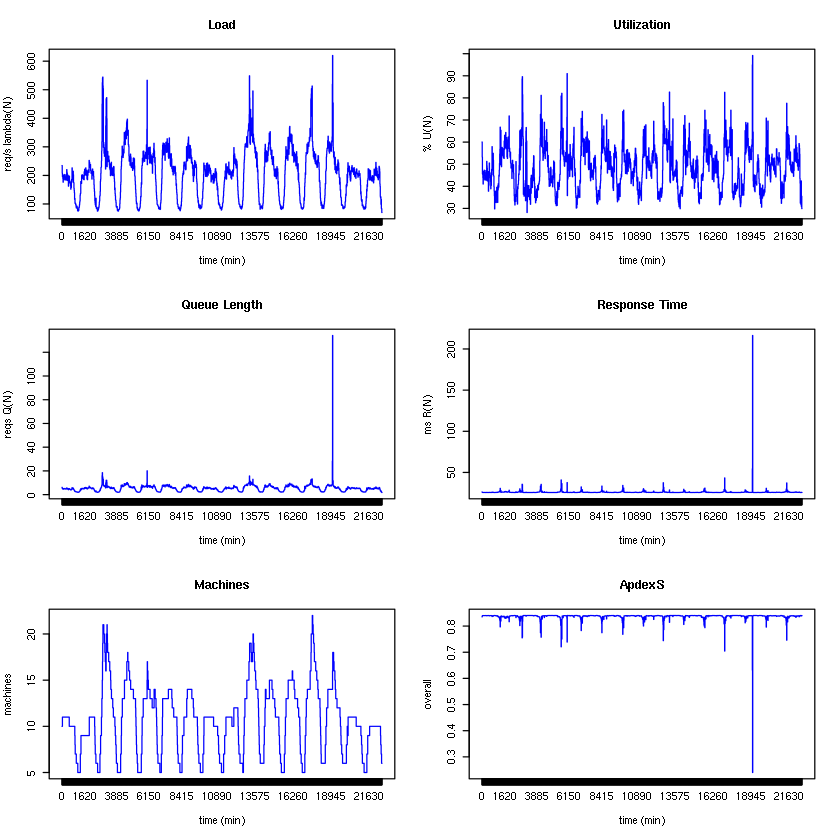

In [21]:
sixplot()

In [22]:
file_name
write.csv(approach_data, file_name)

[1] "../../data/simulation-data/out-arimax-1-15-29-12.5-25ms.csv"